<a href="https://colab.research.google.com/github/khal-drog0/Breast_Cancer_Histopathology_Classification/blob/main/Drive_Before_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json /root/.kaggle

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/breast-histopathology-images

! unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [17]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image
import gc

In [18]:
from glob import glob
data = glob('../IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [19]:
# import cv2
# import matplotlib.pyplot as plt

# for i in data[:5]:
#     img = cv2.imread(i)
#     img_1 = cv2.resize(img, (200, 200))
#     plt.imshow(img_1, cmap = 'binary')
#     plt.show()

In [20]:
import random

def randomSamples(imageData):
    lst = list()
    while(len(lst) != 25000):
        a = random.choice(imageData)

        if a not in lst:
            lst.append(a)

    return lst

In [21]:
img_size = 32

In [22]:
import cv2
import matplotlib.pyplot as plt

images = list()
labels = list()
newData = list()

newData = randomSamples(data)

for i in newData:
    if i.endswith('.png'):
        label = i[-5]
        img = cv2.imread(i)
        img_1 = cv2.resize(img, (img_size, img_size))
        images.append(img_1)
        labels.append(label)

In [23]:
len(images)

25000

In [24]:
x = np.stack(images)

In [25]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [26]:
x = x / 255

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = 0.25)

In [28]:
print('len(x_train):', len(x_train))
print('len(x_test):', len(x_test))
print('len(y_train):', len(y_train))
print('len(y_test):', len(y_test))

len(x_train): 18750
len(x_test): 6250
len(y_train): 18750
len(y_test): 6250


# Building the Neural Network

In [29]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, RepeatVector, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import EfficientNetB3
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import L2

def nn_model():
    model = models.Sequential()
    model.add(EfficientNetB3(include_top = False, weights = 'imagenet', input_shape = (img_size, img_size, 3)))
    
    # model.add(layers.Dense(128, activation = 'relu', kernel_regularizer = L2(0.00001)))
    
    # model.add(layers.Dropout(0.4))
    # model.add(layers.GlobalAveragePooling2D())
    # model.add(layers.Flatten())
    # model.add(layers.Dense(128, activation = 'relu', kernel_regularizer = L2(0.00001)))
    # model.add(layers.RepeatVector(2))
    model.add(layers.Flatten())
    
    # model.add(layers.Dense(2, activation = 'sigmoid'))
    model.add(layers.Dense(2, activation = 'softmax'))

    return model

model = nn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1, 1, 1536)       10783535  
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 3074      
                                                                 
Total params: 10,786,609
Trainable params: 10,699,306
Non-trainable params: 87,303
_________________________________________________________________


In [30]:
from tensorflow.keras.optimizers import Adam

# opt = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad =  False)
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the model

In [31]:
history = model.fit(x, y, epochs = 25, validation_split = 0.4, batch_size = 64)

Epoch 1/25
235/235 [==============================] - 295s 1s/step - loss: 0.6891 - accuracy: 0.6095 - val_loss: 0.8646 - val_accuracy: 0.2849
Epoch 2/25
235/235 [==============================] - 264s 1s/step - loss: 0.5827 - accuracy: 0.7278 - val_loss: 0.7442 - val_accuracy: 0.4508
Epoch 3/25
235/235 [==============================] - 263s 1s/step - loss: 0.5289 - accuracy: 0.7731 - val_loss: 0.6510 - val_accuracy: 0.6830
Epoch 4/25
235/235 [==============================] - 261s 1s/step - loss: 0.4849 - accuracy: 0.7975 - val_loss: 0.6263 - val_accuracy: 0.6699
Epoch 5/25
235/235 [==============================] - 259s 1s/step - loss: 0.4593 - accuracy: 0.8110 - val_loss: 0.4787 - val_accuracy: 0.8012
Epoch 6/25
235/235 [==============================] - 262s 1s/step - loss: 0.4421 - accuracy: 0.8161 - val_loss: 0.4782 - val_accuracy: 0.7931
Epoch 7/25
235/235 [==============================] - 261s 1s/step - loss: 0.4216 - accuracy: 0.8257 - val_loss: 0.4363 - val_accuracy: 0.8250

In [34]:
import tensorflow

# Reduce learing rate if the learning seems to have become constant

rlronp = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    mode = 'min',
    min_lr = 1e-6,
    patience = 2,
    verbose = 1
    )

estop = tensorflow.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 3, 
    verbose = 1,
    restore_best_weights = True
)

In [35]:
history_with_callbacks = model.fit(
    x,
    y,
    epochs = 25,
    validation_split = 0.4,
    callbacks = [rlronp, estop]
)

Epoch 1/25
469/469 [==============================] - 364s 776ms/step - loss: 0.3401 - accuracy: 0.8597 - val_loss: 0.5361 - val_accuracy: 0.7340 - lr: 1.0000e-05
Epoch 2/25
469/469 [==============================] - 344s 734ms/step - loss: 0.3335 - accuracy: 0.8585 - val_loss: 0.4246 - val_accuracy: 0.8169 - lr: 1.0000e-05
Epoch 3/25
469/469 [==============================] - 334s 713ms/step - loss: 0.3276 - accuracy: 0.8649 - val_loss: 0.6035 - val_accuracy: 0.6798 - lr: 1.0000e-05
Epoch 4/25
469/469 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8711
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
469/469 [==============================] - 336s 716ms/step - loss: 0.3165 - accuracy: 0.8711 - val_loss: 0.4347 - val_accuracy: 0.8116 - lr: 1.0000e-05
Epoch 5/25
469/469 [==============================] - 356s 759ms/step - loss: 0.3153 - accuracy: 0.8683 - val_loss: 0.4001 - val_accuracy: 0.8300 - lr: 2.0000e-06
Epoch 6/25
469/469 [===

# Evaluating the model

In [36]:
loss, accuracy = model.evaluate(x_test, y_test)

196/196 [==============================] - 23s 115ms/step - loss: 0.3045 - accuracy: 0.8781


In [37]:
# Save the model
model.save('drive_before_vae.h5')
# new_model = tensorflow.keras.models.load_model('before.h5')
# new_model.summary()

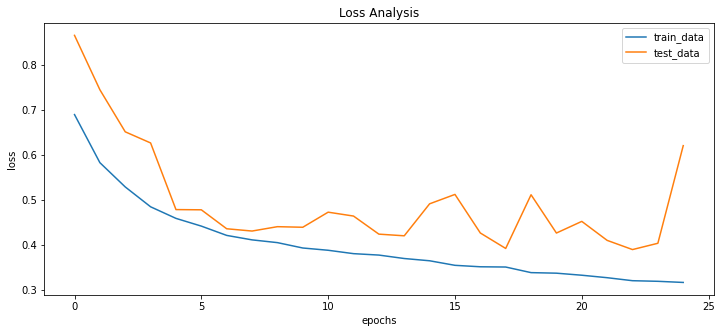

In [38]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data', 'test_data'])
plt.title('Loss Analysis')
plt.show()

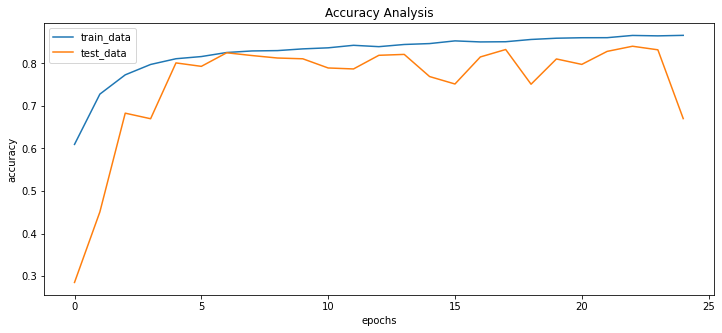

In [39]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data', 'test_data'])
plt.title('Accuracy Analysis')
plt.show()